# Bayesian Model Specification for YOLO Performance Monitor

## 1. Data Model

### Observed Data
- Frame-level variance measurements from YOLO detection model
- These variances represent confidence fluctuations across frames in video clips
- Data is organized as:
  - $C_b$: Set of baseline clips (known good performance)
  - Each clip $c \in C_b$ contains a sequence of frame variances $\{x_{c,1}, x_{c,2}, ..., x_{c,n_c}\}$
  - $n_c$: Number of frames in clip $c$ (typically 450)

### Temporal Structure
- Frame variances within a clip exhibit temporal correlation
- To address this, we use block averaging:
  - Block size $b$ (default: 15 frames)
  - For each clip $c$, compute block averages $\{y_{c,1}, y_{c,2}, ..., y_{c,m_c}\}$
  - Where $y_{c,j} = \frac{1}{b} \sum_{i=(j-1)b+1}^{jb} x_{c,i}$ for complete blocks
  - And $m_c \approx n_c/b$ (typically reducing 450 frames to ~30 measurements)

## 2. Probabilistic Model

### Likelihood Function
- We model block-averaged variances using a gamma distribution:
  - $y_{c,j} \sim \text{Gamma}(\alpha, \beta)$
  - Where $\alpha$ is the shape parameter and $\beta$ is the rate parameter
  - The gamma distribution is appropriate because:
    - Variances are always positive
    - The distribution is often right-skewed
    - It provides flexibility to model various shapes of variance distributions

### Prior Distributions
- For the gamma shape parameter $\alpha$:
  - $\alpha \sim \text{Gamma}(\alpha_0, \beta_0)$
  - Where $\alpha_0 = 2.0$ and $\beta_0 = 0.5$ (moderately informative)
  
- For the gamma rate parameter $\beta$:
  - $\beta \sim \text{Gamma}(\alpha'_0, \beta'_0)$
  - Where $\alpha'_0 = 2.0$ and $\beta'_0 = 0.5$ (moderately informative)

- These priors are weakly informative, allowing the data to dominate when sufficient observations are available

## 3. Posterior Inference

### MCMC Sampling
- We use Markov Chain Monte Carlo (MCMC) to sample from the posterior distribution:
  - $p(\alpha, \beta | \{y_{c,j}\}) \propto p(\{y_{c,j}\} | \alpha, \beta) \times p(\alpha) \times p(\beta)$
  - We collect $N$ samples (default: 1000) after tuning
  - This gives us sets $\{\alpha_1, \alpha_2, ..., \alpha_N\}$ and $\{\beta_1, \beta_2, ..., \beta_N\}$

### Posterior Predictive Distribution
- The posterior predictive distribution represents our uncertainty about future observations:
  - $p(y_{\text{new}} | \{y_{c,j}\}) = \int p(y_{\text{new}} | \alpha, \beta) \times p(\alpha, \beta | \{y_{c,j}\}) d\alpha d\beta$
  - We approximate this through Monte Carlo integration:
    - Draw parameters $(\alpha_i, \beta_i)$ from the posterior
    - Generate $y_{\text{new}} \sim \text{Gamma}(\alpha_i, \beta_i)$
    - Repeat to build predictive distribution

## 4. Anomaly Detection Framework

### Credible Intervals
- We establish credible intervals from the posterior predictive distribution:
  - $(L, U)$: $(1-\gamma)/2$ and $(1+\gamma)/2$ quantiles of the predictive distribution
  - Where $\gamma$ is the credible interval level (default: 0.95)
  - New clips with mean variance outside this interval are statistically anomalous

### Predictive Log-Likelihood
- For a new clip $c_{\text{new}}$ with block-averaged variances $\{y_{\text{new},j}\}$:
  - Calculate log-likelihood under each posterior sample:
    - $\ell_i = \sum_j \log p(y_{\text{new},j} | \alpha_i, \beta_i)$
  - Compute average log-likelihood across posterior samples:
    - $\bar{\ell} = \frac{1}{N} \sum_{i=1}^{N} \ell_i$
  - Calculate likelihood percentile relative to predictive distribution
    - This tells us how extreme the new clip is compared to expected clips

### Decision Criteria
A clip is flagged as having issues when all three conditions are met:
1. **Statistical Anomaly**: Mean variance falls outside the credible interval
2. **Practical Significance**: Relative deviation exceeds minimum threshold $\delta$ (default: 0.2 or 20%)
   - Relative deviation: $\frac{\bar{x}_{\text{new}} - \bar{x}_{\text{baseline}}}{\bar{x}_{\text{baseline}}}$
   - Where $\bar{x}_{\text{new}}$ is the mean variance of the new clip
   - And $\bar{x}_{\text{baseline}}$ is the mean variance across all baseline clips
3. **Correct Direction**: Deviation is positive (higher variance indicates worse performance)

## 5. Bayesian Updating

### Incorporating New Baseline Clips
When a new clip is confirmed as good performance:
1. Add the clip to the set of baseline clips
2. Re-establish the baseline by updating the full model
   - The previous posterior effectively becomes our new prior
   - The new clip data updates our knowledge via Bayes' rule

## 6. Relationship to Original Implementation

The Bayesian model extends the original implementation by:
1. Properly accounting for parameter uncertainty instead of point estimates
2. Handling temporal correlation through block averaging
3. Using the posterior predictive distribution instead of likelihood thresholds
4. Providing probabilities and credible intervals instead of binary decisions
5. Enabling proper Bayesian updating as new data arrives

This formulation maintains the core logic of the original approach while addressing its statistical limitations.

In [1]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import pymc as pm
import warnings
warnings.filterwarnings('ignore')

class BayesianYOLOMonitor:
    def __init__(self, block_size=15, min_deviation_threshold=0.2,
                 buffer_prior_alpha=9, buffer_prior_beta=1,
                 credible_interval=0.95, mcmc_samples=1000):
        """
        Initialize Hybrid Bayesian YOLO Performance Monitor
        
        Parameters:
        - block_size: Size of frame blocks for averaging (to handle temporal correlation)
        - min_deviation_threshold: Minimum relative deviation to be considered significant
        - buffer_prior_alpha, buffer_prior_beta: Prior for buffer factor
          (default gives a distribution centered around 0.9)
        - credible_interval: Credible interval for anomaly detection (e.g., 0.95 for 95%)
        - mcmc_samples: Number of posterior samples to generate
        """
        # Parameters for handling temporal correlation
        self.block_size = block_size
        
        # Parameters for practical significance
        self.min_deviation_threshold = min_deviation_threshold
        
        # Parameters for buffer factor
        self.buffer_prior_alpha = buffer_prior_alpha
        self.buffer_prior_beta = buffer_prior_beta
        
        # Parameters for posterior predictive distribution
        self.credible_interval = credible_interval
        self.mcmc_samples = mcmc_samples
        
        # Initialize storage for model and results
        self.model = None
        self.trace = None
        self.baseline_clips_raw = []
        self.baseline_blocked_variances = []
        self.baseline_mean_variance = None
        
        # Posterior samples
        self.alpha_posterior = None
        self.beta_posterior = None
        self.min_log_prob_posterior = None
        self.threshold_posterior = None
        self.baseline_credible_interval = None
    
    def _block_average(self, frame_variances):
        """
        Average frame variances in blocks to reduce temporal correlation
        
        Parameters:
        - frame_variances: Array of frame variances
        
        Returns:
        - block_averages: Array of block-averaged variances
        """
        # Reshape to handle incomplete final block
        n_frames = len(frame_variances)
        n_complete_blocks = n_frames // self.block_size
        
        # Handle complete blocks
        if n_complete_blocks > 0:
            # Reshape and average complete blocks
            reshaped = np.array(frame_variances[:n_complete_blocks * self.block_size])
            reshaped = reshaped.reshape(n_complete_blocks, self.block_size)
            block_averages = np.mean(reshaped, axis=1).tolist()
            
            # Handle remaining frames (if any)
            remaining = frame_variances[n_complete_blocks * self.block_size:]
            if len(remaining) > 0:
                block_averages.append(np.mean(remaining))
        else:
            # If fewer frames than block_size, just take the mean
            block_averages = [np.mean(frame_variances)]
            
        return np.array(block_averages)
    
    def establish_baseline(self, baseline_clips, visualize=False):
        """
        Establish baseline using frame-level data with Bayesian estimation
        
        Parameters:
        - baseline_clips: List of frame variance arrays from good clips
        - visualize: Whether to visualize the baseline distributions
        
        Returns:
        - baseline_info: Dictionary with baseline statistics
        """
        # Store raw clips for reference
        self.baseline_clips_raw = baseline_clips
        
        # Apply block averaging to reduce temporal correlation
        blocked_clips = [self._block_average(clip) for clip in baseline_clips]
        self.baseline_blocked_variances = blocked_clips
        
        # Combine all blocked variances
        all_blocked_variances = np.concatenate(blocked_clips)
        
        # Calculate baseline mean variance (for practical significance)
        all_frame_variances = []
        for clip in baseline_clips:
            all_frame_variances.extend(clip)
        self.baseline_mean_variance = np.mean(all_frame_variances)
        
        # Fit Bayesian gamma model using PyMC
        with pm.Model() as self.model:
            # Prior for shape parameter (gamma distribution)
            alpha = pm.Gamma('alpha', alpha=2.0, beta=0.5)
            
            # Prior for rate parameter (gamma distribution)
            beta = pm.Gamma('beta', alpha=2.0, beta=0.5)
            
            # Likelihood of observing the block-averaged variances
            likelihood = pm.Gamma('likelihood', alpha=alpha, beta=beta, 
                                  observed=all_blocked_variances)
            
            # Calculate clip-level log probabilities (from other implementation)
            clip_log_probs = []
            for i, clip in enumerate(blocked_clips):
                # Calculate log probability for each clip
                frame_log_probs = pm.Potential(f'clip_{i}_log_prob', 
                                              pm.Gamma.logp(clip, alpha, beta))
                avg_log_prob = pm.Deterministic(f'avg_log_prob_{i}', 
                                              pm.math.sum(frame_log_probs) / len(clip))
                clip_log_probs.append(avg_log_prob)
            
            # Minimum baseline log prob
            min_log_prob = pm.Deterministic('min_log_prob', 
                                           pm.math.min(pm.math.stack(clip_log_probs)))
            
            # Sample from the posterior
            self.trace = pm.sample(self.mcmc_samples, tune=500, 
                                  return_inferencedata=True, target_accept=0.95)
        
        # Extract posterior samples
        self.alpha_posterior = self.trace.posterior.alpha.values.flatten()
        self.beta_posterior = self.trace.posterior.beta.values.flatten()
        self.min_log_prob_posterior = self.trace.posterior.min_log_prob.values.flatten()
        
        # Calculate buffer-adjusted threshold (from other implementation)
        buffer_samples = np.random.beta(self.buffer_prior_alpha, self.buffer_prior_beta, 
                                       len(self.alpha_posterior))
        self.threshold_posterior = self.min_log_prob_posterior * buffer_samples
        
        # Calculate credible interval for predictive distribution (from my implementation)
        def generate_predictive_sample(alpha, beta):
            return np.random.gamma(alpha, 1/beta)
        
        predictive_samples = np.array([
            generate_predictive_sample(alpha, beta) 
            for alpha, beta in zip(self.alpha_posterior, self.beta_posterior)
        ])
        
        lower_bound = np.percentile(predictive_samples, (1 - self.credible_interval) * 100 / 2)
        upper_bound = np.percentile(predictive_samples, 100 - (1 - self.credible_interval) * 100 / 2)
        self.baseline_credible_interval = (lower_bound, upper_bound)
        
        if visualize:
            self.visualize_baseline()
        
        return {
            'alpha_mean': np.mean(self.alpha_posterior),
            'beta_mean': np.mean(self.beta_posterior),
            'baseline_mean_variance': self.baseline_mean_variance,
            'min_log_prob_mean': np.mean(self.min_log_prob_posterior),
            'threshold_mean': np.mean(self.threshold_posterior),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]),
            'baseline_credible_interval': self.baseline_credible_interval,
            'block_size': self.block_size
        }
    
    def check_performance(self, clip_variances):
        """
        Check clip performance using hybrid Bayesian approach
        
        Parameters:
        - clip_variances: Frame confidence variances from current clip
        
        Returns:
        - result: Detection result with detailed metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Block average the clip variances
        blocked_variances = self._block_average(clip_variances)
        
        # Calculate mean variance for practical significance
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation for practical significance
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        
        # Direction check - positive deviation means worse performance
        is_worse_direction = relative_deviation > 0
        
        # ===== Approach 1: Buffer-Factor Threshold (from other implementation) =====
        # Calculate log likelihood for new clip using posterior samples
        n_samples = len(self.alpha_posterior)
        clip_log_likelihoods = np.zeros(n_samples)
        
        for i in range(n_samples):
            # For each posterior sample of parameters
            alpha, beta = self.alpha_posterior[i], self.beta_posterior[i]
            # Calculate log likelihood of clip given these parameters
            frame_log_probs = gamma.logpdf(blocked_variances, alpha, scale=1/beta)
            clip_log_likelihoods[i] = np.mean(frame_log_probs)
        
        # Calculate probability that clip log likelihood is below threshold
        p_below_threshold = np.mean(clip_log_likelihoods < self.threshold_posterior)
        
        # ===== Approach 2: Posterior Predictive (from my implementation) =====
        # Check if mean variance falls outside credible interval
        outside_credible_interval = (mean_variance < self.baseline_credible_interval[0] or 
                                    mean_variance > self.baseline_credible_interval[1])
        
        # Generate reference samples from posterior predictive for percentile
        n_reference = 1000
        reference_log_likelihoods = []
        
        for _ in range(n_reference):
            # Random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            sample = np.random.gamma(alpha, 1/beta, size=len(blocked_variances))
            
            # Calculate log likelihood of this sample
            sample_log_likelihood = np.mean(gamma.logpdf(sample, alpha, scale=1/beta))
            reference_log_likelihoods.append(sample_log_likelihood)
        
        # Calculate percentile
        mean_log_likelihood = np.mean(clip_log_likelihoods)
        likelihood_percentile = np.mean(reference_log_likelihoods <= mean_log_likelihood) * 100
        
        # ===== Combined Decision =====
        # Hybrid approach - use both statistical indicators with practical significance
        p_has_issue = 0.0
        if is_practically_significant and is_worse_direction:
            # Combine both statistical indicators (average them)
            p_has_issue = (p_below_threshold + int(outside_credible_interval)) / 2
        
        # Final dictionary output with all metrics
        return {
            'p_has_issue': p_has_issue,
            'has_issue': p_has_issue > 0.5,  # Binary decision based on probability
            'p_below_threshold': p_below_threshold,
            'outside_credible_interval': outside_credible_interval,
            'likelihood_percentile': likelihood_percentile,
            'is_practically_significant': is_practically_significant,
            'is_worse_direction': is_worse_direction,
            'mean_variance': mean_variance,
            'baseline_mean_variance': self.baseline_mean_variance,
            'relative_deviation': relative_deviation * 100,  # Present as percentage
            'min_deviation_threshold': self.min_deviation_threshold * 100,  # Present as percentage
            'mean_log_likelihood': mean_log_likelihood,
            'log_likelihood_95ci': np.percentile(clip_log_likelihoods, [2.5, 97.5]),
            'threshold_mean': np.mean(self.threshold_posterior),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]),
            'baseline_credible_interval': self.baseline_credible_interval
        }
    
    def update_baseline(self, new_clip_variances):
        """
        Update baseline distribution with new data using Bayesian update
        
        Parameters:
        - new_clip_variances: Frame variances from new clip to add to baseline
        
        Returns:
        - updated_params: Dictionary with updated parameters
        """
        # Add new clip to raw baseline clips
        self.baseline_clips_raw.append(new_clip_variances)
        
        # Re-establish baseline with all clips
        return self.establish_baseline(self.baseline_clips_raw, visualize=False)
    
    def visualize_baseline(self):
        """
        Visualize baseline distributions, posterior, and predictive distributions
        """
        # Create a figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Plot all frame variances from baseline clips with posterior fit
        ax = axs[0, 0]
        
        # Combine all variances for histogram
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
        
        # Plot histogram
        ax.hist(all_variances, bins=50, alpha=0.7, density=True, color='green', 
                label='Baseline frame variances')
        
        # Plot the posterior expected gamma distribution
        x = np.linspace(min(all_variances), max(all_variances), 1000)
        
        # Plot multiple posterior samples
        n_curves = 50
        indices = np.random.choice(len(self.alpha_posterior), n_curves)
        for i in indices:
            alpha = self.alpha_posterior[i]
            beta = self.beta_posterior[i]
            pdf = gamma.pdf(x, alpha, scale=1/beta)
            ax.plot(x, pdf, 'r-', lw=0.1, alpha=0.1)
        
        # Plot the posterior mean gamma distribution
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        pdf_mean = gamma.pdf(x, alpha_mean, scale=1/beta_mean)
        ax.plot(x, pdf_mean, 'r-', lw=2, 
                label=f'Posterior mean gamma (α≈{alpha_mean:.2f}, β≈{beta_mean:.2f})')
        
        # Mark the credible interval
        ax.axvline(x=self.baseline_credible_interval[0], color='purple', linestyle='--')
        ax.axvline(x=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark the mean variance
        ax.axvline(x=self.baseline_mean_variance, color='blue', linestyle='-', 
                   label=f'Mean variance: {self.baseline_mean_variance:.6f}')
        
        ax.set_title('Baseline Frame Variance Distribution with Posterior Fits')
        ax.set_xlabel('Variance')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Plot posterior distribution for alpha
        ax = axs[0, 1]
        
        # Plot histogram of posterior samples
        ax.hist(self.alpha_posterior, bins=30, alpha=0.7, color='blue',
                density=True, label='Posterior samples')
        
        # Mark posterior mean
        ax.axvline(x=alpha_mean, color='red', linestyle='-',
                   label=f'Posterior mean: {alpha_mean:.2f}')
        
        # Calculate 95% credible interval
        alpha_lower = np.percentile(self.alpha_posterior, 2.5)
        alpha_upper = np.percentile(self.alpha_posterior, 97.5)
        
        # Mark credible interval
        ax.axvline(x=alpha_lower, color='red', linestyle='--')
        ax.axvline(x=alpha_upper, color='red', linestyle='--',
                   label=f'95% CI: [{alpha_lower:.2f}, {alpha_upper:.2f}]')
        
        ax.set_title('Posterior Distribution for Shape Parameter (α)')
        ax.set_xlabel('α value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Plot posterior distribution for log-likelihood threshold
        ax = axs[1, 0]
        
        # Plot histogram of posterior threshold samples
        ax.hist(self.threshold_posterior, bins=30, alpha=0.7, color='green',
                density=True, label='Buffer-adjusted thresholds')
        
        # Mark posterior mean
        threshold_mean = np.mean(self.threshold_posterior)
        ax.axvline(x=threshold_mean, color='red', linestyle='-',
                   label=f'Mean threshold: {threshold_mean:.2f}')
        
        # Calculate 95% credible interval
        threshold_lower = np.percentile(self.threshold_posterior, 2.5)
        threshold_upper = np.percentile(self.threshold_posterior, 97.5)
        
        # Mark credible interval
        ax.axvline(x=threshold_lower, color='red', linestyle='--')
        ax.axvline(x=threshold_upper, color='red', linestyle='--',
                   label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
        
        ax.set_title('Posterior Distribution for Log-Likelihood Threshold')
        ax.set_xlabel('Threshold Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Plot clip-level log likelihoods
        ax = axs[1, 1]
        
        # Extract clip log probabilities from trace
        clip_log_probs = []
        for i in range(len(self.baseline_blocked_variances)):
            var_name = f'avg_log_prob_{i}'
            if var_name in self.trace.posterior:
                clip_probs = self.trace.posterior[var_name].values.flatten()
                clip_log_probs.append(clip_probs)
        
        # Create boxplot of clip log probabilities
        if clip_log_probs:
            ax.boxplot(clip_log_probs)
            
            # Plot threshold distribution
            ax.axhline(y=threshold_mean, color='red', linestyle='-',
                      label=f'Mean threshold: {threshold_mean:.2f}')
            ax.axhline(y=threshold_lower, color='red', linestyle='--')
            ax.axhline(y=threshold_upper, color='red', linestyle='--',
                      label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
            
            ax.set_title('Clip Log-Likelihoods vs. Threshold')
            ax.set_xlabel('Clip Index')
            ax.set_ylabel('Log-Likelihood')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create an additional figure for posterior predictive
        plt.figure(figsize=(10, 6))
        
        # Generate samples from posterior predictive distribution
        n_samples = 5000
        pred_samples = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            pred_samples[i] = np.random.gamma(alpha, 1/beta)
        
        # Plot histogram
        plt.hist(pred_samples, bins=50, alpha=0.7, color='purple', density=True,
                label='Posterior predictive samples')
        
        # Mark credible interval
        plt.axvline(x=self.baseline_credible_interval[0], color='red', linestyle='--')
        plt.axvline(x=self.baseline_credible_interval[1], color='red', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark mean
        plt.axvline(x=np.mean(pred_samples), color='blue', linestyle='-',
                  label=f'Predictive mean: {np.mean(pred_samples):.6f}')
        
        plt.title('Posterior Predictive Distribution')
        plt.xlabel('Variance')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_results(self, test_clips, labels):
        """
        Visualize test results
        
        Parameters:
        - test_clips: List of clips to visualize
        - labels: Binary labels (1=issue, 0=good)
        """
        # Calculate metrics for each clip
        results = []
        for clip in test_clips:
            results.append(self.check_performance(clip))
        
        # Extract metrics
        mean_variances = [r['mean_variance'] for r in results]
        percentiles = [r['likelihood_percentile'] for r in results]
        p_below_thresholds = [r['p_below_threshold'] for r in results]
        deviations = [r['relative_deviation'] for r in results]
        outside_intervals = [r['outside_credible_interval'] for r in results]
        p_has_issues = [r['p_has_issue'] for r in results]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # 1. Mean variances with credible interval
        plt.subplot(2, 1, 1)
        
        # Define colors and markers
        colors = ['green' if label == 0 else 'red' for label in labels]
        shapes = ['o' if label == 0 else 'X' for label in labels]
        
        # Plot each clip
        for i, (mv, c, m) in enumerate(zip(mean_variances, colors, shapes)):
            plt.scatter(i, mv, color=c, marker=m, s=100)
        
        # Add clip labels
        for i, mv in enumerate(mean_variances):
            plt.text(i, mv, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Plot baseline mean and credible interval
        plt.axhline(y=self.baseline_mean_variance, color='blue', linestyle='-',
                   label=f'Baseline mean: {self.baseline_mean_variance:.6f}')
        plt.axhline(y=self.baseline_credible_interval[0], color='purple', linestyle='--')
        plt.axhline(y=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        plt.axhline(y=self.baseline_mean_variance * (1 + self.min_deviation_threshold),
                   color='orange', linestyle='-.',
                   label=f'Practical threshold (+{self.min_deviation_threshold*100:.1f}%)')
        
        plt.title('Mean Variance by Clip with Bayesian Credible Interval')
        plt.xlabel('Clip Index')
        plt.ylabel('Mean Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Probability of issue
        plt.subplot(2, 1, 2)
        
        # Sort by probability for better visualization
        sorted_indices = np.argsort(p_has_issues)
        sorted_probs = [p_has_issues[i] for i in sorted_indices]
        sorted_colors = [colors[i] for i in sorted_indices]
        sorted_shapes = [shapes[i] for i in sorted_indices]
        
        # Plot bars
        for i, (p, c) in enumerate(zip(sorted_probs, sorted_colors)):
            plt.bar(i, p, color=c, alpha=0.7)
        
        # Add clip indices as labels
        for i, idx in enumerate(sorted_indices):
            plt.text(i, sorted_probs[i] + 0.05, f"{idx}", fontsize=9, ha='center')
        
        # Add threshold line
        plt.axhline(y=0.5, color='red', linestyle='--',
                   label='Decision threshold (p=0.5)')
        
        plt.title('Probability of Issue by Clip (Sorted)')
        plt.xlabel('Sorted Clip Index')
        plt.ylabel('Probability of Issue')
        plt.ylim(0, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a metrics scatter plot
        plt.figure(figsize=(10, 8))
        
        # Plot percentile vs. probability
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 0],
                   [pct for pct, l in zip(percentiles, labels) if l == 0],
                   color='green', marker='o', s=100, label='Good clips')
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 1],
                   [pct for pct, l in zip(percentiles, labels) if l == 1],
                   color='red', marker='X', s=100, label='Issue clips')
        
        # Add clip indices
        for i, (pt, pct) in enumerate(zip(p_below_thresholds, percentiles)):
            plt.text(pt, pct, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Add threshold lines
        plt.axvline(x=0.5, color='red', linestyle='--',
                   label='Threshold probability = 0.5')
        plt.axhline(y=5, color='red', linestyle='--',
                   label='Percentile threshold = 5%')
        
        plt.title('Threshold Probability vs. Likelihood Percentile')
        plt.xlabel('Probability Below Threshold')
        plt.ylabel('Likelihood Percentile (lower = more anomalous)')
        plt.xlim(-0.05, 1.05)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def run_test(self, test_clips, labels):
        """
        Run test on labeled clips to evaluate monitor performance
        
        Parameters:
        - test_clips: List of clips to test
        - labels: Binary labels (1=issue, 0=good)
        
        Returns:
        - results: Test results with metrics
        """
        if self.model is None or self.trace is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Test each clip
        results = []
        for clip, label in zip(test_clips, labels):
            result = self.check_performance(clip)
            result['true_label'] = label
            result['correct'] = (result['has_issue'] == bool(label))
            results.append(result)
        
        # Calculate metrics
        true_positives = sum(1 for r in results if r['has_issue'] and r['true_label'])
        false_positives = sum(1 for r in results if r['has_issue'] and not r['true_label'])
        true_negatives = sum(1 for r in results if not r['has_issue'] and not r['true_label'])
        false_negatives = sum(1 for r in results if not r['has_issue'] and r['true_label'])
        
        total = len(results)
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Visualize results
        self.visualize_results(test_clips, labels)
        
        return {
            'results': results,
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'true_positives': true_positives,
                'false_positives': false_positives,
                'true_negatives': true_negatives,
                'false_negatives': false_negatives
            }
        }

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Using 4 clips as baseline:
  0: clip_0017.mp4
  1: clip_0018.mp4
  2: clip_0019.mp4
  3: clip_0020.mp4
Establishing baseline with Bayesian model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 57 seconds.


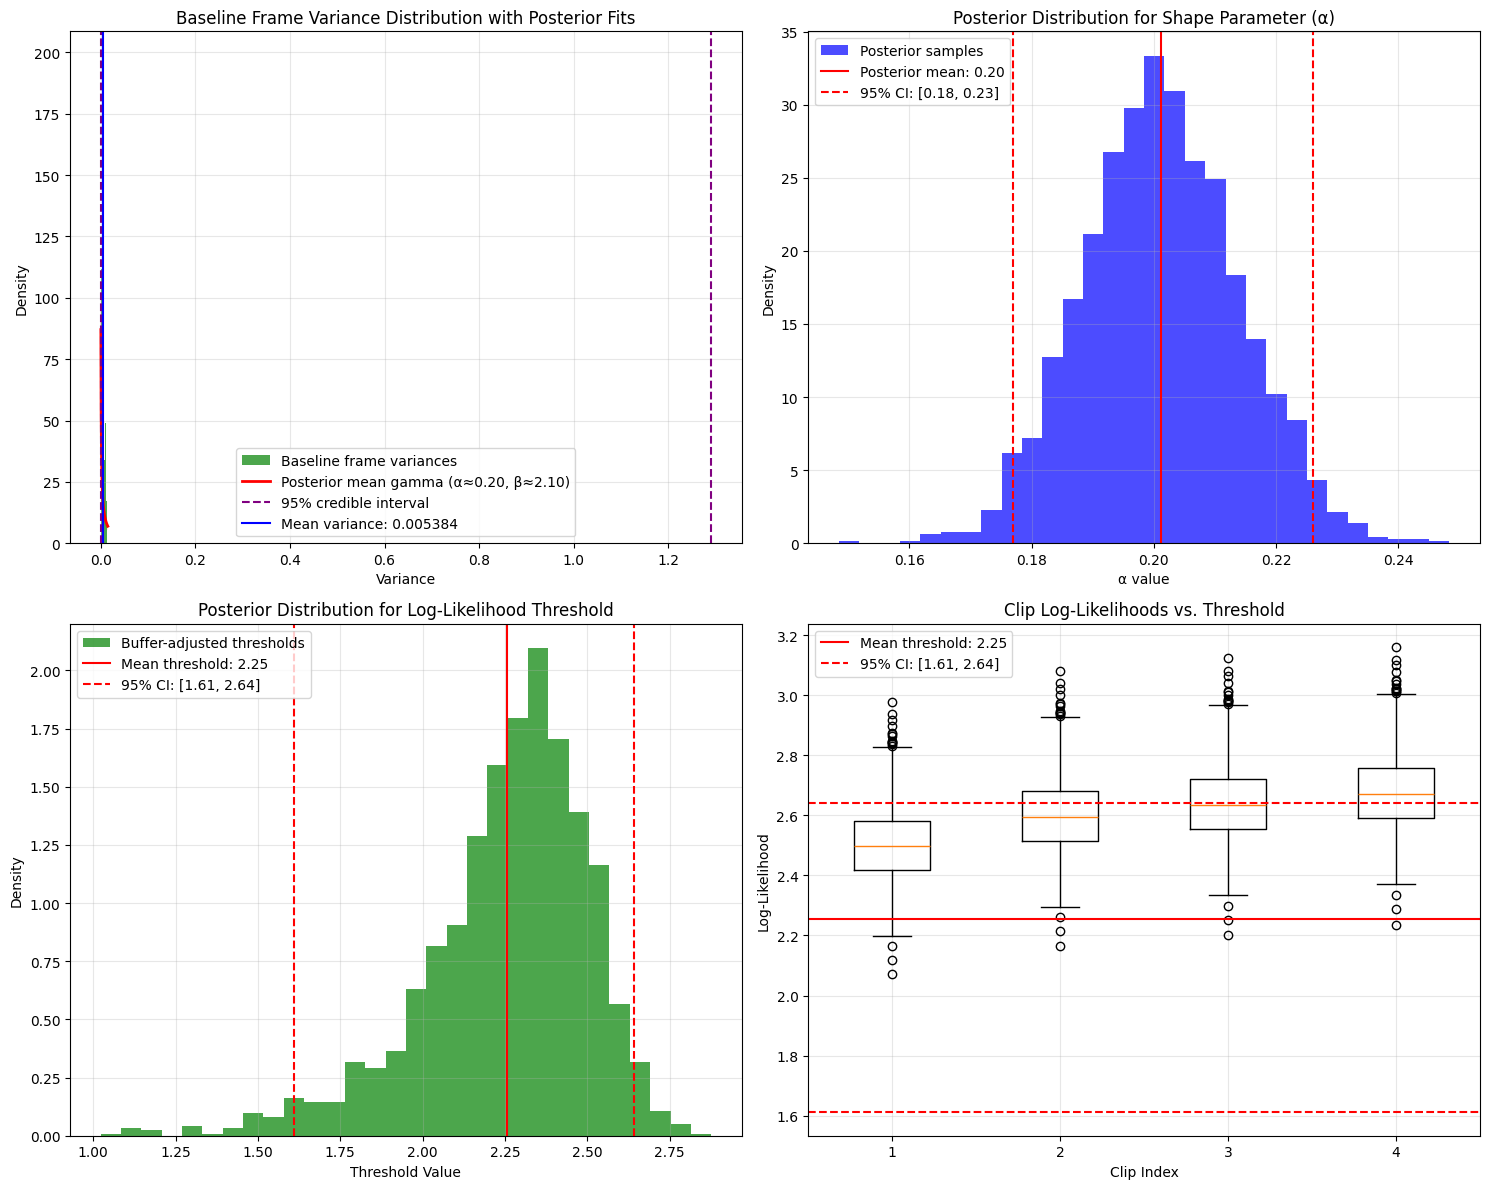

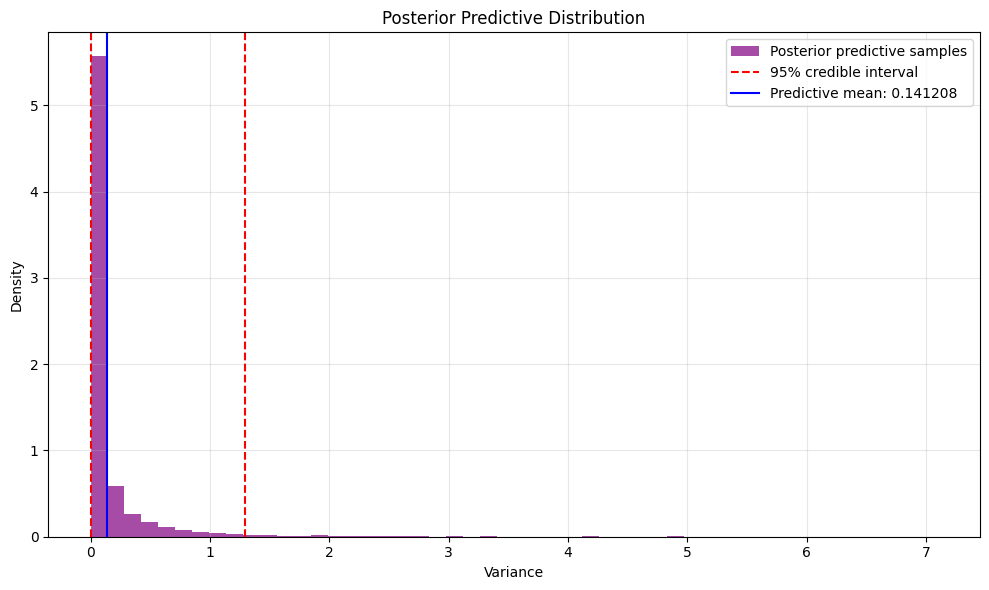

Baseline parameters:
  alpha_mean: 0.20112985787497525
  beta_mean: 2.0966027989453395
  baseline_mean_variance: 0.005383805539332935
  min_log_prob_mean: 2.502080187614671
  threshold_mean: 2.2546461615220807
  threshold_95ci: [1.61067521 2.64114671]
  baseline_credible_interval: (np.float64(6.999667598173365e-09), np.float64(1.2904412525963824))
  block_size: 15

Testing all clips:
Clip 0 (clip_0017.mp4): OK - BASELINE
  Probability of issue: 0.031
  Below threshold probability: 0.062
  Outside credible interval: False
Clip 1 (clip_0018.mp4): OK - BASELINE
  Probability of issue: 0.000
  Below threshold probability: 0.030
  Outside credible interval: False
Clip 2 (clip_0019.mp4): OK - BASELINE
  Probability of issue: 0.000
  Below threshold probability: 0.023
  Outside credible interval: False
Clip 3 (clip_0020.mp4): OK - BASELINE
  Probability of issue: 0.000
  Below threshold probability: 0.015
  Outside credible interval: False
Clip 4 (clip_0021.mp4): OK - CORRECT
  Probability of

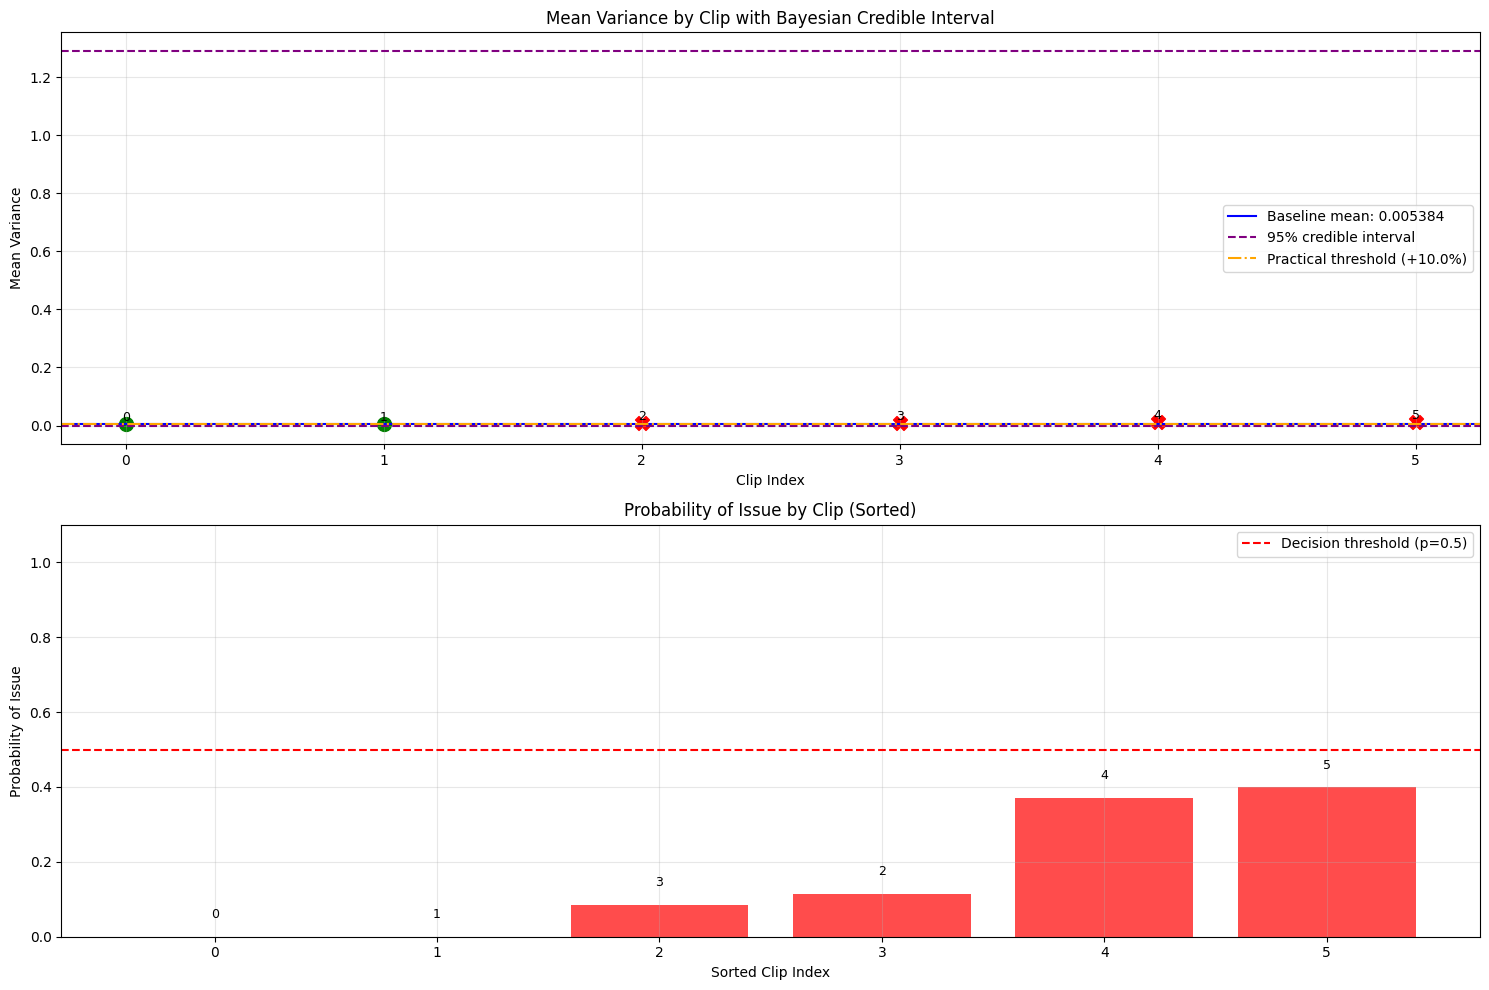

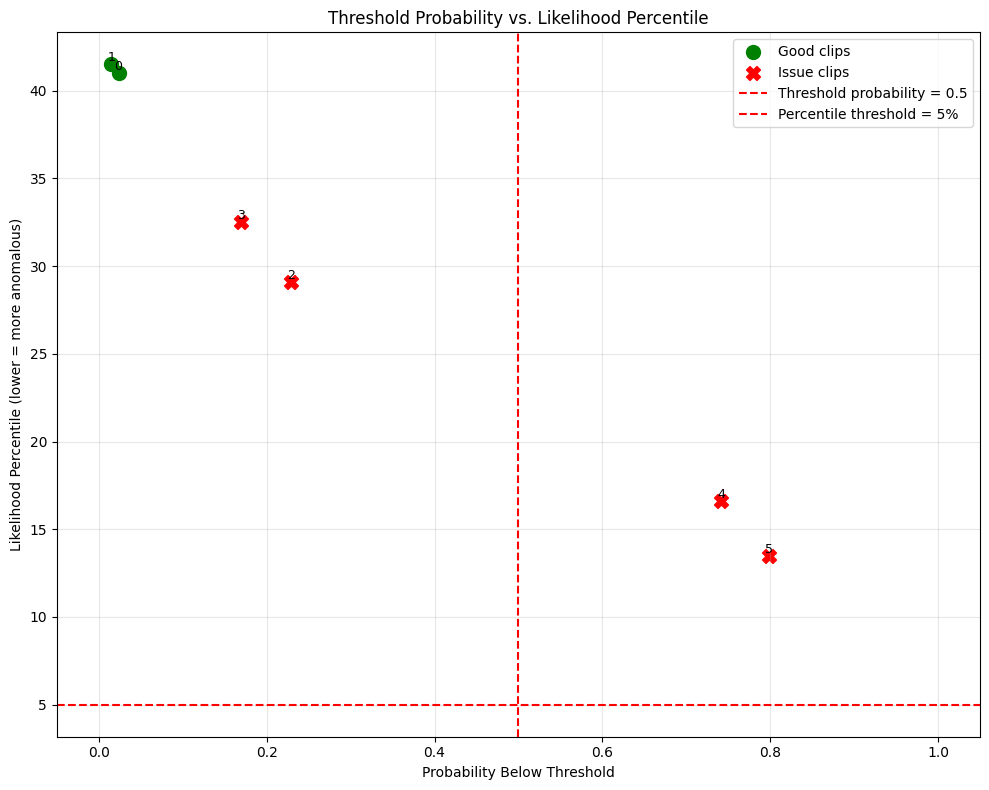


Performance metrics:
  accuracy: 0.3333
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  true_positives: 0.0000
  false_positives: 0.0000
  true_negatives: 2.0000
  false_negatives: 4.0000


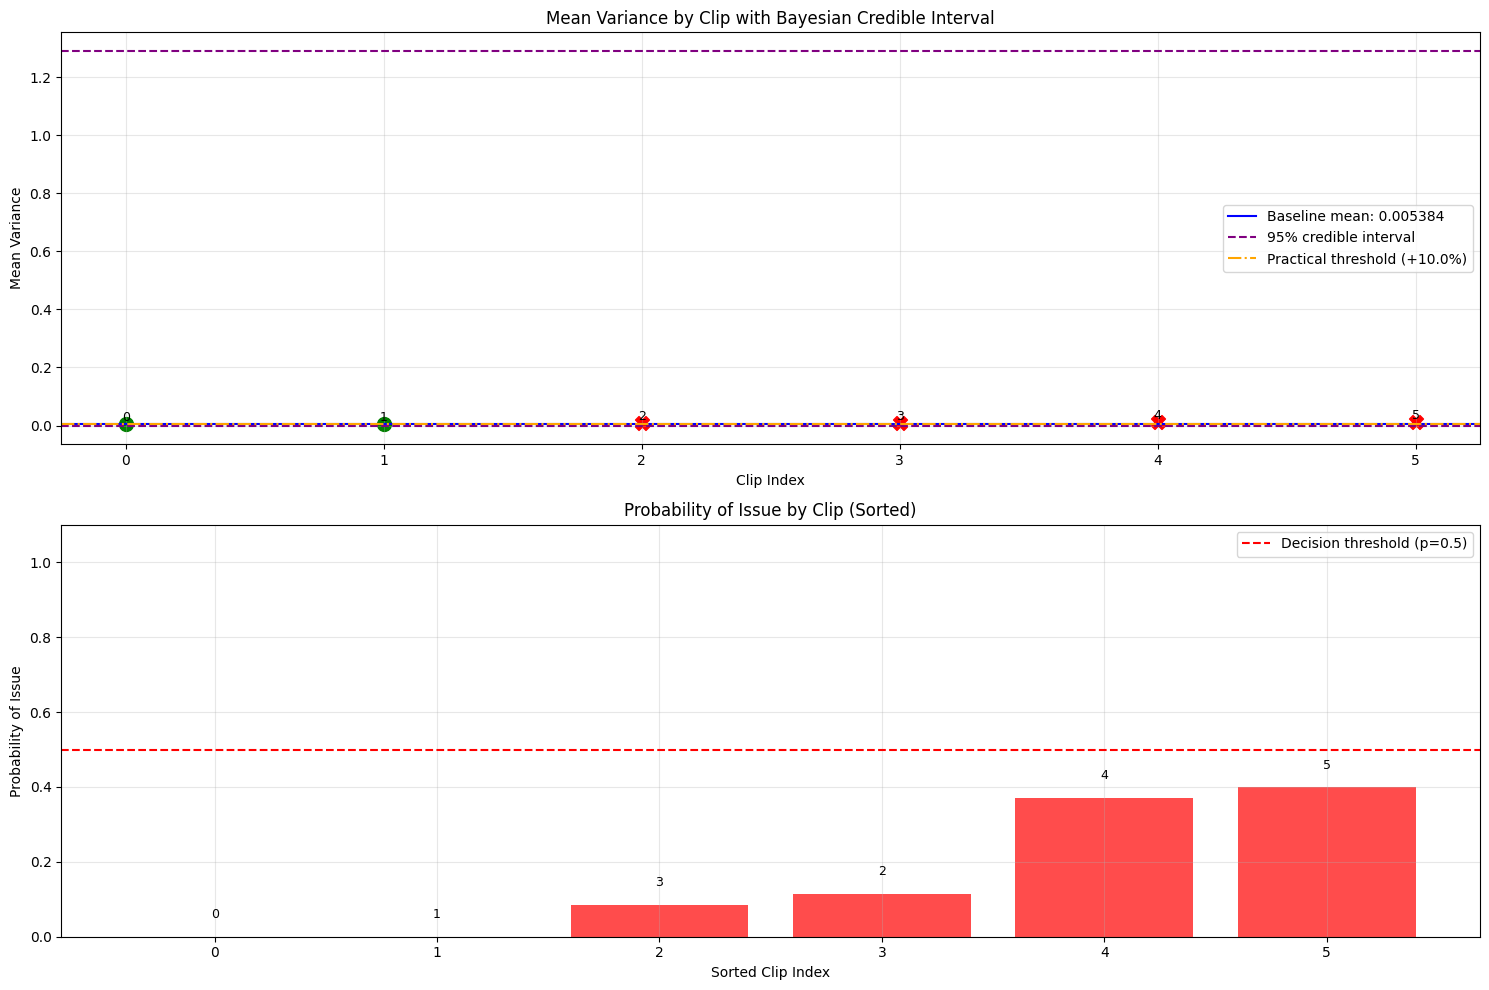

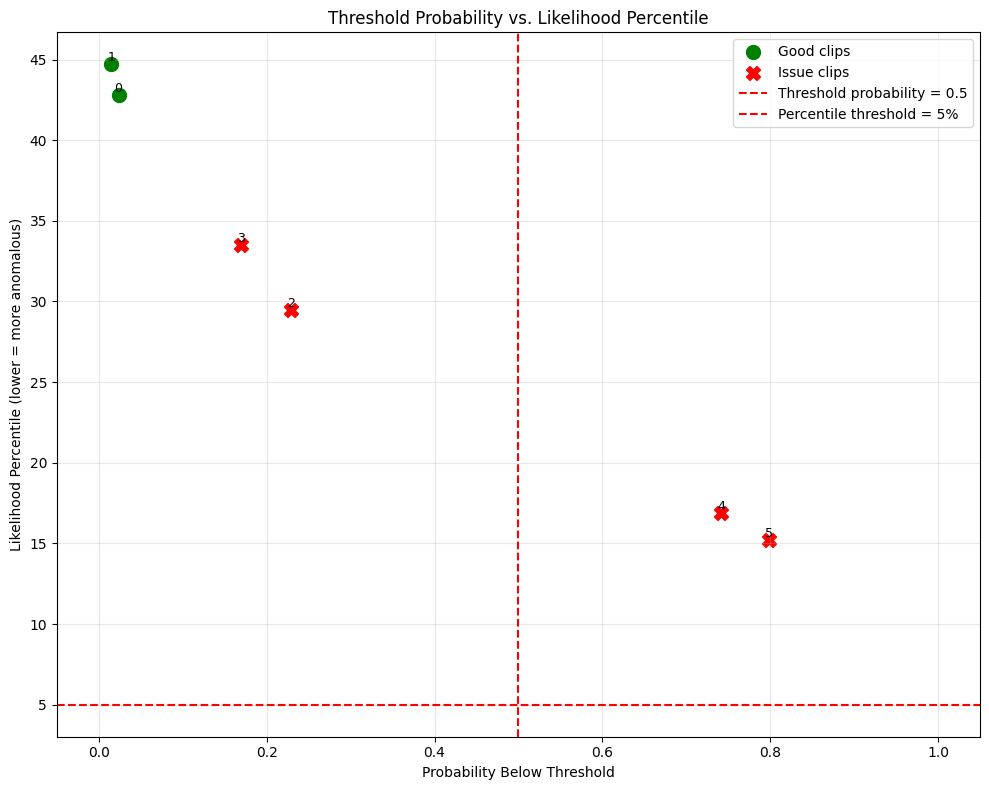


Comparison of detection approaches:
Test clip 0 (true label=0):
  Hybrid approach: Correct (p=0.000)
  Buffer approach: Correct (p=0.024)
  Interval approach: Correct (outside=False)
Test clip 1 (true label=0):
  Hybrid approach: Correct (p=0.000)
  Buffer approach: Correct (p=0.015)
  Interval approach: Correct (outside=False)
Test clip 2 (true label=1):
  Hybrid approach: Wrong (p=0.114)
  Buffer approach: Wrong (p=0.229)
  Interval approach: Wrong (outside=False)
Test clip 3 (true label=1):
  Hybrid approach: Wrong (p=0.085)
  Buffer approach: Wrong (p=0.169)
  Interval approach: Wrong (outside=False)
Test clip 4 (true label=1):
  Hybrid approach: Wrong (p=0.371)
  Buffer approach: Correct (p=0.742)
  Interval approach: Wrong (outside=False)
Test clip 5 (true label=1):
  Hybrid approach: Wrong (p=0.399)
  Buffer approach: Correct (p=0.798)
  Interval approach: Wrong (outside=False)

Accuracy by approach:
  Hybrid approach: 0.3333
  Buffer approach: 0.6667
  Interval approach: 0.333

In [3]:
import os
import numpy as np
import pymc as pm

# Load the saved data
def load_frame_variances(filepath):
    """Load frame variances from pickle file"""
    import pickle
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Load the data
data = load_frame_variances("saved_data/frame_variances_20250430_145054.pkl")

# Extract components
frame_variances = data['frame_variances']
clip_paths = data['clip_paths']
labels = data['labels']

# Find good clip indices
good_indices = [i for i, label in enumerate(labels) if label == 0]
bad_indices = [i for i, label in enumerate(labels) if label == 1]

# Use first 4 good clips as baseline
baseline_indices = good_indices[:4]
baseline_clips = [frame_variances[i] for i in baseline_indices]
baseline_paths = [clip_paths[i] for i in baseline_indices]

print(f"Using {len(baseline_clips)} clips as baseline:")
for i, path in zip(baseline_indices, baseline_paths):
    print(f"  {i}: {os.path.basename(path) if isinstance(path, str) else path}")

# Process MC dropout data by averaging each frame across MC runs
def process_mc_clip(clip):
    """Average each frame's variance across all MC runs"""
    # Get dimensions
    n_runs = len(clip)
    min_frames = min(len(run) for run in clip)
    
    # Average each frame
    avg_variances = []
    for frame_idx in range(min_frames):
        frame_variances = [clip[run_idx][frame_idx] for run_idx in range(n_runs)]
        avg_variances.append(np.mean(frame_variances))
    
    return np.array(avg_variances)

# Process baseline clips
processed_baseline_clips = [process_mc_clip(clip) for clip in baseline_clips]

# Initialize and set up hybrid monitor
# Use a smaller number of MCMC samples for testing
monitor = BayesianYOLOMonitor(
    block_size=15,  # For handling temporal correlation
    min_deviation_threshold=0.1,  # Using your threshold value
    buffer_prior_alpha=9,  # Centered around 0.9
    buffer_prior_beta=1,
    credible_interval=0.95,
    mcmc_samples=500  # Smaller sample size for faster testing
)

# Establish baseline
print("Establishing baseline with Bayesian model...")
baseline_info = monitor.establish_baseline(processed_baseline_clips, visualize=True)
print("Baseline parameters:")
for key, value in baseline_info.items():
    print(f"  {key}: {value}")

# Check all clips by first processing them
print("\nTesting all clips:")
for i, clip in enumerate(frame_variances):
    # Process clip
    processed_clip = process_mc_clip(clip)
    
    # Check performance
    result = monitor.check_performance(processed_clip)
    
    # Is this clip in the baseline?
    in_baseline = i in baseline_indices
    
    # Get expected label (0=good, 1=bad)
    expected = labels[i]
    
    # Format result
    if in_baseline:
        status = "BASELINE"
    elif result['has_issue'] == (expected == 1):
        status = "CORRECT"
    else:
        status = "ERROR"
    
    print(f"Clip {i} ({os.path.basename(clip_paths[i]) if isinstance(clip_paths[i], str) else clip_paths[i]}): " + 
          f"{'Issue detected' if result['has_issue'] else 'OK'} - {status}")
    print(f"  Probability of issue: {result['p_has_issue']:.3f}")
    print(f"  Below threshold probability: {result['p_below_threshold']:.3f}")
    print(f"  Outside credible interval: {result['outside_credible_interval']}")

# Process test clips for evaluation
test_clips = []
test_labels = []
for i in range(len(frame_variances)):
    if i not in baseline_indices:
        processed_clip = process_mc_clip(frame_variances[i])
        test_clips.append(processed_clip)
        test_labels.append(labels[i])

# Evaluate performance
test_results = monitor.run_test(test_clips, test_labels)

print("\nPerformance metrics:")
for metric, value in test_results['metrics'].items():
    if isinstance(value, (int, float)):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Visualize results if desired
monitor.visualize_results(test_clips, test_labels)

# Print out comparison between hybrid and individual approaches
print("\nComparison of detection approaches:")
correct_hybrid = 0
correct_threshold = 0
correct_interval = 0
total = len(test_clips)

for i, (clip, label) in enumerate(zip(test_clips, test_labels)):
    result = monitor.check_performance(clip)
    
    hybrid_correct = (result['has_issue'] == bool(label))
    threshold_correct = ((result['p_below_threshold'] > 0.5) == bool(label))
    interval_correct = (result['outside_credible_interval'] == bool(label))
    
    if hybrid_correct:
        correct_hybrid += 1
    if threshold_correct:
        correct_threshold += 1
    if interval_correct:
        correct_interval += 1
    
    print(f"Test clip {i} (true label={label}):")
    print(f"  Hybrid approach: {'Correct' if hybrid_correct else 'Wrong'} (p={result['p_has_issue']:.3f})")
    print(f"  Buffer approach: {'Correct' if threshold_correct else 'Wrong'} (p={result['p_below_threshold']:.3f})")
    print(f"  Interval approach: {'Correct' if interval_correct else 'Wrong'} (outside={result['outside_credible_interval']})")

print("\nAccuracy by approach:")
print(f"  Hybrid approach: {correct_hybrid/total:.4f}")
print(f"  Buffer approach: {correct_threshold/total:.4f}")
print(f"  Interval approach: {correct_interval/total:.4f}")